In [42]:
%matplotlib inline

In [43]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal

## Assignment and notebook notes
 - Do **NOT** change function names where you are told to fill in.
 - Do **NOT** change the name of this notebook.
 - Before submission make sure to run the entire notebook again an ensures everything works **without** error.
 - **TODO**: List all files you want to submit for grading below in the Python path variable.
 - **TODO**: **Also**, specify your u-id below:

In [44]:
SUBMISSION_LIST = [
    'assignment_1.ipynb',  # Make sure to include this!
    'Q2-5.png',
    'auto-mpg_cleaned.csv'
]

assert('assignment_1.ipynb' in SUBMISSION_LIST)

U_ID = 'u7205329'  # You need to specify

# Check length and typing of U_ID
assert(len(U_ID) == 8)
assert(type(U_ID) == str)

# Section 1: Bayesian Linear Regression

In this question we will implement Bayesian Linear Regression. We will start off with implementing and visualising a simple case, and then progressively add more complexity. We will also recreate the visualisations in the textbook/slides (Bishop, Figure 3.7 Page 155).

## BLR - Simple Line Fitting

We first consider the regression of a simple straight-line fitting example example: a single input variable $x\in\mathbb{R}$, a single target variable $t\in\mathbb{R}$ and the model 
$$y(x,\mathbf{w})=w_0+w_1x.$$

Thus the parameters of the model are summarised by the vector $\mathbf{w}=[w_0, w_1]$. An easier way to think about this model is to map the data points $x$ into a higher dimensional feature space (i.e. to vectors $\boldsymbol{\phi}(x)\in\mathbb{R}^{d}$) and have the model as a linear combination of those features. The above model corresponds to having two simple basis functions
$$\boldsymbol{\phi}(x)=[\phi_0(x),\phi_1(x)]=[1,x]$$
so that 
$$y(x,\mathbf{w})=\mathbf{w}^T\boldsymbol{\phi}(x)=w_0+w_1x.$$

In Bayesian Linear Regression, we first have a prior over parameters, and as we see data we will update the likelihood of the data to get a posterior distribution over the parameters. Let us start with a Gaussian Prior over the parameters 
$$p(\mathbf{w})=\mathcal{N}(\mathbf{w} \mid \mathbf{m}_0, \mathbf{S}_0).$$

Then from lectures we know that the posterior update is given by 
$$
\begin{align}
\mathbf{m}_N &= \mathbf{S}_N(\mathbf{S}_0^{-1}\mathbf{m}_0+\beta\mathbf{\Phi}^T\mathbf{t})\\
\mathbf{S}_N^{-1} &= \mathbf{S}_0^{-1}+\beta\mathbf{\Phi}^T\mathbf{\Phi}
\end{align}
$$

### Question 1.1 [10 Marks]
Derive this from the identitites given in the slides (see Slides 02b slides 9 and 10: Week 2 Linear Regression 2).

### Write Solution Here

We have the likelihood of targets 

$p(\mathbf{t} |  \mathbf{w}, \beta) = N(\mathbf{t} | \Phi^T\mathbf{w}, \beta^{-1}I) \iff t = \phi^T\mathbf{w} + N(0, \beta^{-1}I)$

$E[t] = E[\phi^T\mathbf{w} + N(0, \beta^{-1}I] = \phi^T\mathbf{w}$

and the covariance 
$$
\begin{align}
cov[\Phi^T\mathbf{w} + N(0, \beta^{-1}I] 
&= cov[\Phi^T\mathbf{w}] + cov[N(0, \beta^{-1}I] \\
&= E[(\Phi^T\mathbf{w})(\Phi^T\mathbf{w})^T] + \beta^{-1}I \\
&= E[\Phi^T\mathbf{w}\mathbf{w}^T\Phi] + \beta^{-1}I \\
&= \Phi^TE[\mathbf{w}\mathbf{w}^T]\Phi \beta^{-1}I \\
&= \Phi \mathbf{S}_0\Phi + \beta^{-1}I
\end{align}
$$

So we have the marginal of t 
$$p(\mathbf{t}) = N(\mathbf{t} | \Phi^T\mathbf{w}, \Phi \mathbf{S}_0\Phi + \beta^{-1}I)$$

Letting 
$$\mathbf{S}_n = (\mathbf{S}_0^{-1} + \beta\Phi^T\Phi)^{-1}$$

Using the identities in slide 9, we have the posterior distribution of w
$$p(\mathbf{w} | \mathbf{t}) = N(\mathbf{w} | \mathbf{S}_n ({\beta\Phi^T\mathbf{t} + \mathbf{S}_0^{-1}\mathbf{m}_0}), \mathbf{S}_n)$$

The following code sets up the data for the problem and plots it. You do **not** need to edit the following two Python cells. They are strictly for visualisation. 

In [45]:
## Supporting Cell Do NOT change

np.random.seed(0)
# Set Up Data for the Straight Line problem
true_w = np.array([-0.3, 0.5]) # (2,)
true_function = lambda x: true_w[0] + true_w[1]*x
line_x = np.linspace(-1,1,100) # (100,)
line_y = true_function(line_x) # (100,)
num_points = 30 # We will refer to this as n
noise_sigma = 0.2
beta = 1 / (noise_sigma**2)
data_x = np.random.rand(num_points)*2 -1 # (n,)
data_y = true_function(data_x) + np.random.randn(num_points)*noise_sigma # (n,)

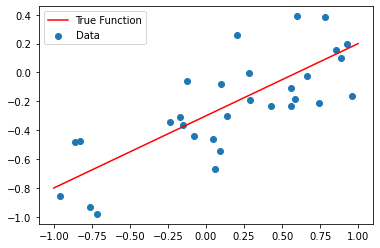

In [46]:
## Supporting Cell Do NOT change

def plot_function(ax, line_x, line_y, data_x, data_y, pred_y=None, std_dev=None):
    ax.plot(line_x, line_y, c='r', label='True Function')
    ax.scatter(data_x, data_y, label='Data')
    if pred_y is not None:
        ax.plot(line_x, pred_y.reshape(-1), label='Prediction')
        if std_dev is not None:
            upper_line = pred_y.reshape(-1) + std_dev.reshape(-1)
            lower_line = pred_y.reshape(-1) - std_dev.reshape(-1)
            ax.fill_between(line_x, lower_line, upper_line, alpha=0.4, color='r')
    ax.legend()
fig, ax = plt.subplots()
plot_function(ax, line_x, line_y, data_x, data_y)
plt.show()

We can now set up our model: define our prior and our design matrix. Our prior is just a Gaussian, let us use mean $\mathbf{0}$ and covariance $\alpha I$ for some hyperparameter $\alpha$. As our model is $y=w_0+w_1x$, our design matrix is $\boldsymbol{\Phi}=[\mathbf{1}, \mathbf{x}]\in\mathbf{R}^{n\times 2}$ where $\mathbf{1}, \mathbf{x}\in\mathbf{R}^{n}$. 

We can then matrix multiply to compute our model for each datapoint: $\mathbf{y}=\boldsymbol{\Phi}\mathbf{w}$ where $\mathbf{w}\in\mathbb{R}^{2\times 1}$ so that $\mathbf{y}\in\mathbb{R}^{n\times 1}$. Note that we have changed $\mathbf{w}$ from $\mathbb{R}^{2}$ to $\mathbb{R}^{2\times 1}$ for convenience in the matrix multiplication, we often skip details like that in the maths but staying consistent matters in the code.

In [47]:
## Supporting Cell Do NOT change

num_features = 2 # We will refer to this as d
initial_w_mean = np.array([0,0]).reshape(2,1) # (d,1)
initial_w_cov = 0.01*np.eye(2) # (d,d)

def make_phi(data):
    # Takes 1-D data and maps it into d dimensional features
    data_vec = data.reshape(-1) # (n,)
    return np.stack([np.ones_like(data_vec), data_vec], axis=0).T # (n,d)
features = make_phi(data_x) # (n,d)
targets = data_y.reshape(-1,1) # (n,1)

### Question 1.2 [15 Marks]
Implement Equation 3.50 and 3.51 to get the posterior given data points. A quick reminder, posterior update is given by
$$
\begin{align}
\mathbf{m}_N &= \mathbf{S}_N(\mathbf{S}_0^{-1}\mathbf{m}_0+\beta\mathbf{\Phi}^T\mathbf{t}) \tag{3.50}\\
\mathbf{S}_N^{-1} &= \mathbf{S}_0^{-1}+\beta\mathbf{\Phi}^T\mathbf{\Phi} \tag{3.51}
\end{align}
$$

In [48]:
def update_w_mean_and_cov(old_w_mean, old_w_cov, features, targets, beta):
    # TODO: Implement Equation 3.50 and 3.51 to get the posterior given features and targets

    w_cov = np.linalg.inv(np.linalg.inv(old_w_cov) + beta*(features.T@features))
    w_mean = w_cov @ (np.linalg.inv(old_w_cov)@old_w_mean + beta*(features.T@targets))
    return w_mean, w_cov # (d,1), (d,d)

Now we can visualise the affect of running updating the covariance for certain data points. We also plot the updated posterior.

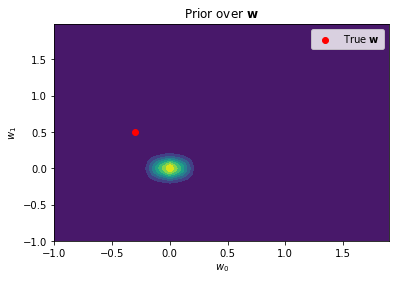

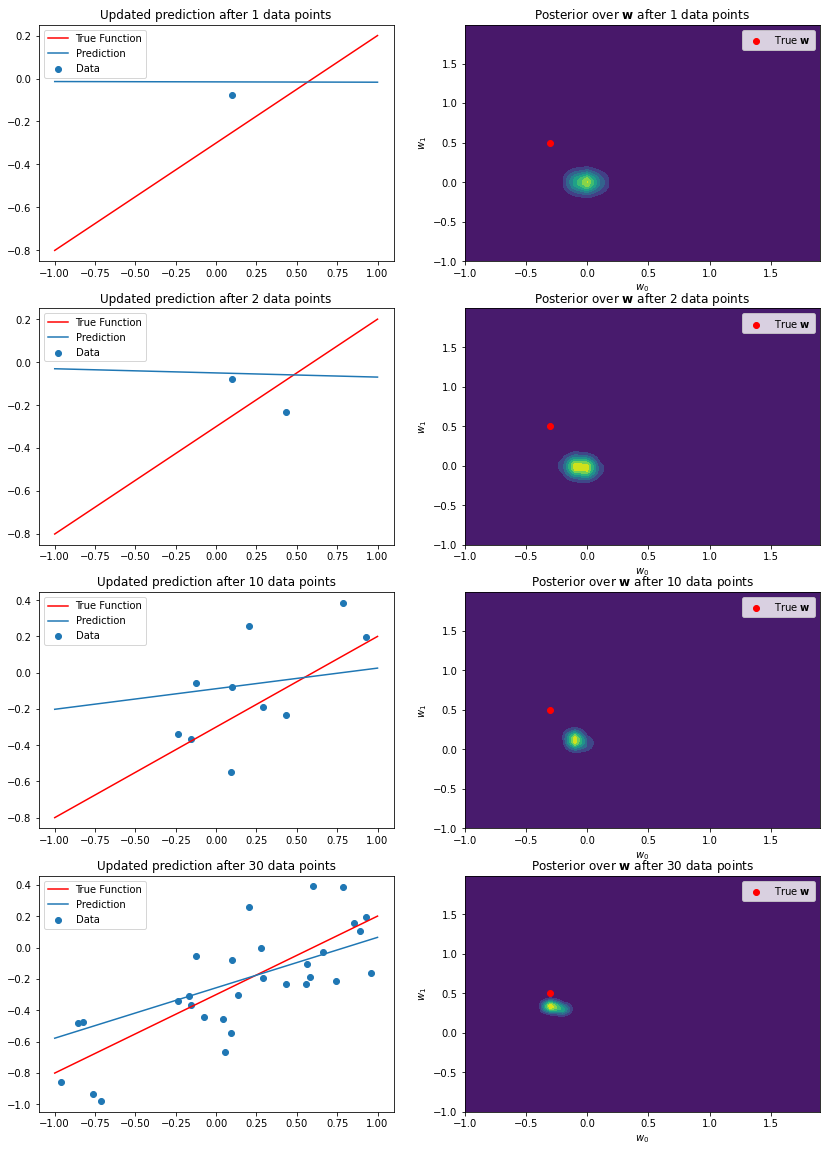

In [49]:
## Supporting Cell Do NOT change

def plot_gaussian(ax, mean, cov):
    x, y = np.mgrid[-1:2:0.1, -1:2:.01]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean.reshape(-1), cov)
    ax.contourf(x, y, rv.pdf(pos))
    ax.set_xlabel('$w_0$'); ax.set_ylabel('$w_1$')
    ax.scatter(true_w[0], true_w[1], c='r', label='True $\mathbf{w}$')
    ax.legend()

def run_simple_blr_model(initial_w_mean, initial_w_cov, line_x, line_y, data_x, data_y, features, targets, beta):
    if initial_w_mean is None or initial_w_cov is None:
        print("value for mean or cov is None")
        return
    fig, ax = plt.subplots()
    plot_gaussian(ax, initial_w_mean, initial_w_cov)
    plt.title('Prior over $\mathbf{w}$')
    plt.show()
    subsets = [1, 2, 10, 30]
    fig, axs = plt.subplots(len(subsets), 2, figsize=(14,len(subsets)*5))
    for i, num in enumerate(subsets):
        new_w_mean, new_w_cov = update_w_mean_and_cov(initial_w_mean, initial_w_cov, features[:num], targets[:num], beta)
        if new_w_mean is None or new_w_cov is None:
            print("update_w_mean_and_cov has not been implemented")
            return
        pred_y = make_phi(line_x) @ new_w_mean
        plot_function(axs[i,0], line_x, line_y, data_x[:num], data_y[:num], pred_y=pred_y)
        axs[i,0].set_title('Updated prediction after {} data points'.format(num))
        plot_gaussian(axs[i,1],new_w_mean, new_w_cov)
        axs[i,1].set_title('Posterior over $\mathbf{{w}}$ after {} data points'.format(num))
run_simple_blr_model(initial_w_mean, initial_w_cov, line_x, line_y, data_x, data_y, features, targets, beta)

### Question 1.3 [5 Marks]
It doesn't seem to be learning a good line of best fit. The problem is that the prior is too biased, and there is not enough data to remove such bias. Try changing the values of the prior to something reasonable, and try running the code again. If you are confused have a look at Figure 3.7 in the textbook and see what is different. **Explain why your choices for the values of the prior makes sense.**

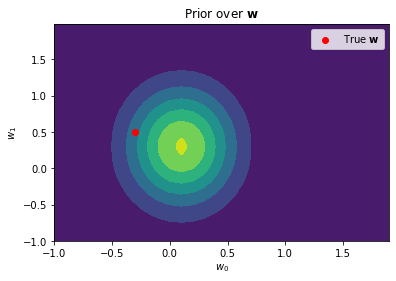

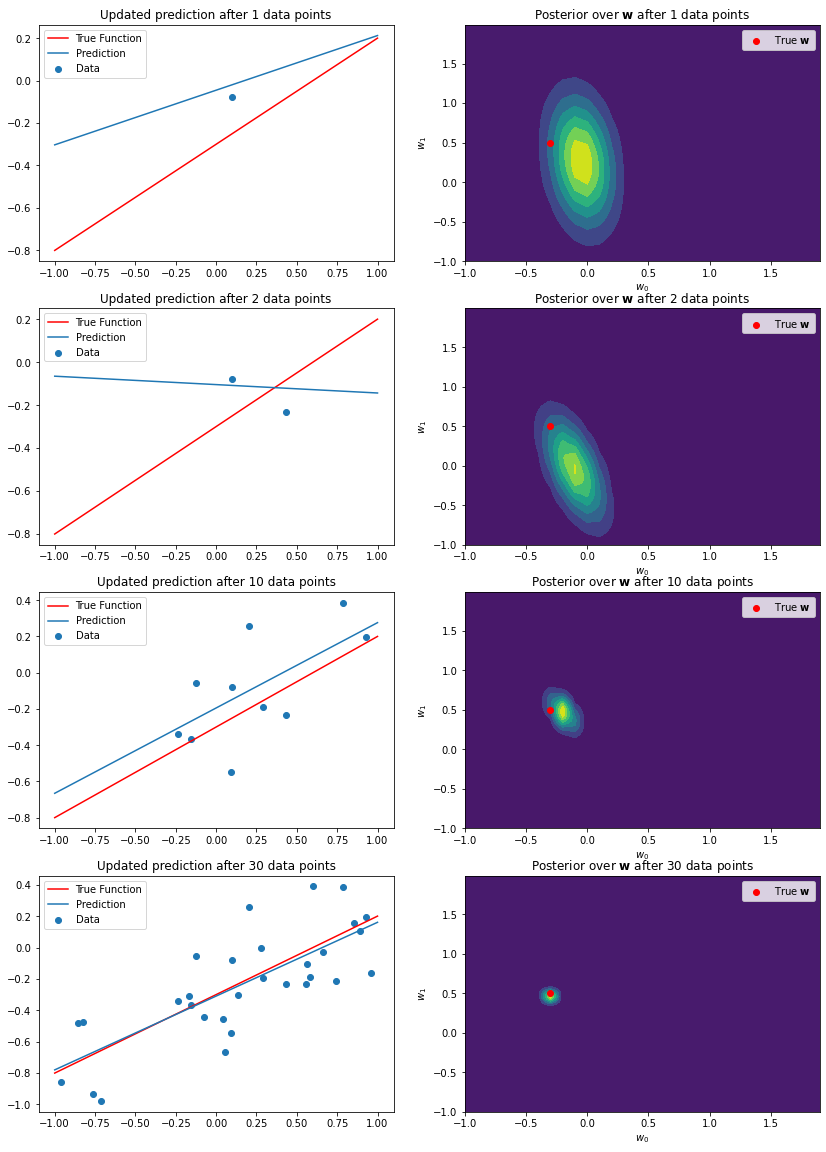

In [50]:
initial_mean = np.array([0.1, 0.3]).reshape(2,1) # TODO: Set this value, (d, 1)

initial_cov = np.eye(2)
np.fill_diagonal(initial_cov, initial_mean)
#initial_mean = np.array([0.1, 0.5]).reshape(2,1) # TODO: Set this value, (d, 1)


run_simple_blr_model(initial_mean, initial_cov, line_x, line_y, data_x, data_y, features, targets, beta)

#### Explain why you chose this value here

## Non-linear Fitting + Predictive Distribution
We will now consider a slightly more difficult example: with data generated from a sine wave.

In [51]:
## Supporting Cell Do NOT change

# Setup data / parameters
np.random.seed(1)
true_function = lambda x: np.sin(x*2*np.pi)
line_x = np.linspace(0,1,100) # (100,)
line_y = true_function(line_x) # (100,)
num_points = 25 # n
noise_sigma = 0.2
beta = 1 / (noise_sigma**2)
data_x = np.random.rand(num_points) # (n,)
data_y = true_function(data_x) + np.random.randn(num_points)*noise_sigma # (n,)

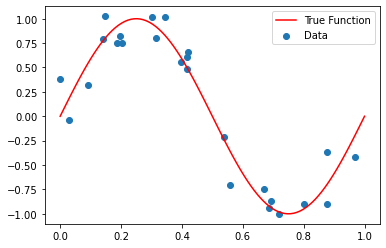

In [52]:
## Supporting Cell Do NOT change

fig, ax = plt.subplots()
plot_function(ax, line_x, line_y, data_x, data_y)
plt.show()

### Question 1.4 [5 Marks]

When our data is non-linear we need to use non-linear basis functions within our linear regression model to model it. 

We can see that our data is bounded, it goes up and down but its distance doesn't keep increasing away from 0. A good set of basis functions would be to use Gaussian basis functions of the form
$$
\begin{align}
    \phi(x;\mu_j,s) &= \exp\left\{-\frac{(x-\mu_j)^2}{2s^2}\right\}, \tag{3.4}
\end{align}
$$
(note the Textbook uses such basis functions to make Figure 3.8).

In particular, let us use the following basis function mapping:
$$
\begin{align}
    \boldsymbol\Phi\left(x\right) &= \left[1,\phi\left(x;0,0.1\right),\phi\left(x;\frac{1}{8},0.1\right),\phi\left(x;\frac{2}{8},0.1\right),\phi\left(x;\frac{3}{8},0.1\right),\phi\left(x;\frac{4}{8},0.1\right),\phi\left(x;\frac{5}{8},0.1\right),\phi\left(x;\frac{6}{8},0.1\right),\phi\left(x;\frac{7}{8},0.1\right),\phi\left(x;1,0.1\right)\right]
\end{align}
$$

Also redo the previous setup for Bayesian Linear Regresion with the following parameters:
$$
\begin{align}
    \mathbf{m}_0 &=0\in\mathbb{R}^{10\times 1}\\
    S_N &= I_{10}\in\mathbb{R}^{10\times 10}
\end{align}
$$

In [53]:
# Define our initial BLR parameters
num_features = 10 # d

def initial_params_exp():
    # TODO
    initial_w_mean = np.zeros(num_features).reshape(num_features, 1) # TODO , (d,1)
    initial_w_cov = np.eye(num_features) # TODO , (d,d)
    
    return initial_w_mean, initial_w_cov

initial_w_mean, initial_w_cov = initial_params_exp()

def gaussian_basis(x, muj, s):
    return np.exp(-((x-muj)**2)/(2*s**2))

def make_phi_exp(points):
    basis_points = np.zeros((len(points), 10))
    
    for n in range(len(points)):
        
        x = points[n]
        theta_x = [1]
        s = 0.1
        for i in range(0,9):
            mu_j = i/8
            res = gaussian_basis(x, mu_j, s)
            theta_x.append(res)

        basis_points[n,:] = np.array(theta_x)

    return basis_points
    
features = make_phi_exp(data_x) # (n,d)
targets = data_y.reshape(-1,1) # (n,1)

assert(features is not None)
assert(initial_w_mean is not None)
assert(initial_w_cov is not None)

### Question 1.5 [5 Marks]

Often we don't care about the value or uncertainty of $\mathbf{w}$, but the value and the uncertainty that results for predictions $t$ for new values of $x$. The predictive distribution of the target value $t$ for our Gaussian Model is a Gaussian specified by

\begin{align*}
p(t \mid x, \mathbf{t},\alpha,\beta) &= \mathcal{N}\left(t\mid \mathbf{m}_N^T\boldsymbol{\phi}(x),\sigma^2_N(x)\right) \tag{3.58}\\
\sigma^2_N(x) &= \frac{1}{\beta} + \boldsymbol{\phi}(x)^TS_N\boldsymbol{\phi}(x) \tag{3.59}
\end{align*}

Then in the next cell, implement the predictive distribution equations.

In [54]:
def predictive_dist(features, w_mean, w_cov, beta):
    # features (n,d), w_mean (d,1), w_cov (d,d)
    
    pred_y_mean = features@w_mean
    pred_y_sigma = 1/beta + (features@w_cov)@features.T
    return pred_y_mean, pred_y_sigma # (n,1), (n,n)

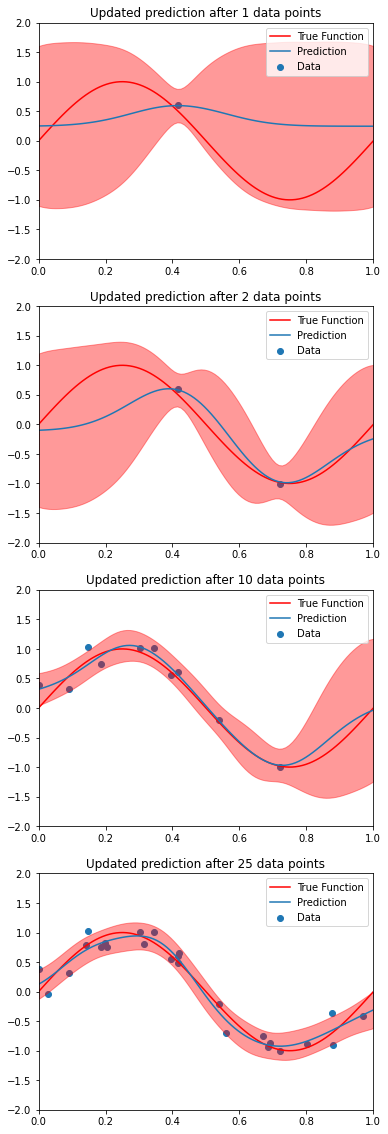

In [55]:
## Supporting Cell Do NOT change

def run_simple_blr_model(initial_mean, initial_cov, line_x, line_y, data_x, data_y, features, targets, beta):
    if initial_mean is None or initial_cov is None:
        print("value for mean or cov is None")
        return
    subsets = [1, 2, 10, 25]
    fig, axs = plt.subplots(len(subsets), 1, figsize=(6,len(subsets)*5))
    for i, num in enumerate(subsets):
        new_w_mean, new_w_cov = update_w_mean_and_cov(initial_w_mean, initial_w_cov, features[:num], targets[:num], beta)
        line_features = make_phi_exp(line_x) # (100,d)
        pred_y_mean, pred_y_cov = predictive_dist(line_features, new_w_mean, new_w_cov, beta) # (100,d), (100,100)
        if pred_y_mean is None or pred_y_cov is None:
            print("Predictive Distribution has not been implemented")
            return
        pred_y = (make_phi_exp(line_x) @ new_w_mean).reshape(-1) # (100,)
        std_dev = np.sqrt(np.diag(pred_y_cov)).reshape(-1) # (100,)
        plot_function(axs[i], line_x, line_y, data_x[:num], data_y[:num], pred_y, std_dev)
        axs[i].set_ylim(-2,2); axs[i].set_xlim(0,1)
        axs[i].set_title('Updated prediction after {} data points'.format(num))
    plt.show()
run_simple_blr_model(initial_mean, initial_cov, line_x, line_y, data_x, data_y, features, targets, beta)

## Real World Data

We now will apply Bayesian Linear Regression to a real world dataset. This dataset is the [Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/Auto+MPG) from the [UCI ML Repository](https://archive.ics.uci.edu/ml/index.php). The dataset has been slightly preprocessed/filtered. The aim of the task is to predict the city-cycle fuel consumption in miles per gallon (mpg) from 8 variables (all are numerical, and will be treated as continuous for this task). A description of each variable can be found in the dataset link.

To properly test our model, we will split the 392 instances into a train set (of $n=294$ instances) that we will fit our model on, and a test set (of $n'=98$ instances) that we will report the relative error on.

As this is not synthetic data, we don't know what the noise in the measurements of the target variable are. Thus we will estimate it.

In [56]:
## Supporting Cell Do NOT change

# Get the data
df = pd.read_csv('auto-mpg_cleaned.csv')
names = df.columns; print("Variables are {}, we are regressing mpg given the rest.".format(list(names)))
target_df = df['mpg']
data_df = df[['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin']]
# Decide train-test splits
np.random.seed(0)
random_perm = np.random.permutation(len(data_df))
train_indices = random_perm[:int(len(data_df)*0.75)]
test_indices = random_perm[int(len(data_df)*0.75):]

# Set up train and test set
train_data = data_df.iloc[train_indices].values # (n,7)
test_data = data_df.iloc[test_indices].values # (n',7)
train_targets = target_df.iloc[train_indices].values.reshape(-1,1) # (n,1)
test_targets = target_df.iloc[test_indices].values.reshape(-1,1) # (n',1)

# Estimate the noise in the targets
noise_sigma = 1
beta = 1 / (noise_sigma**2)

Variables are ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name'], we are regressing mpg given the rest.


### Question 1.6 [10 Marks]

As before, make an initial mean and covariance that makes sense, as well as a feature matrix $\boldsymbol{\Phi}$. Then run the following code to see the performance on the train and test set, and the visualisations of the predictions on the test set. The given features have a test relative error of about 11.5%, you should be able to reduce it below 10 (and try to reduce it even further).

In [191]:
num_features = 8 # TODO: Change as required, d

initial_w_mean = np.random.uniform(0, 15, num_features).reshape(num_features, 1)
initial_w_cov = np.eye(num_features)

def make_phi_realworld(data):
    # TODO: Make sensible basis functions that do not have any parameters of its own. We have given a very simple
    # one, improve upon this
    out = np.zeros((len(data), num_features))
    nrow, ncol = len(data), num_features
    for i in range(nrow):
        out[i,0] = 1
        for j in range(1, ncol-1):
            if j == 1:
                out[i,j+1] = np.sin(data[i,j]) + 2 #data[i,j] - 6 #
            elif j == 2:
                out[i,j+1] = data[i,j]**(1/5)
            elif j == 3:
                out[i,j+1] = data[i,j]**(1/5)
            elif j == 4:
                out[i,j+1] = np.log(data[i,j])/3
            elif j == 5:
                out[i,j+1] = data[i,j]**(1/3)
            elif j == 6:
                out[i,j+1] = data[i,j]-70 #np.sin(data[i,j]) 
            elif j == 7:
                out[i,j+1] = data[i,j] #np.sin(data[i,j])
            
    return out
    #return np.concatenate([np.ones(len(data)).reshape(-1,1), data], axis=1) # TODO: Improve this, (n,d=8), gets around 11.5 rel error

train_features = make_phi_realworld(train_data) # (n,d)
test_features = make_phi_realworld(test_data) # (n',d)

Train Relative Error 10.643774231075447
Test Relative Error 9.88877606234269


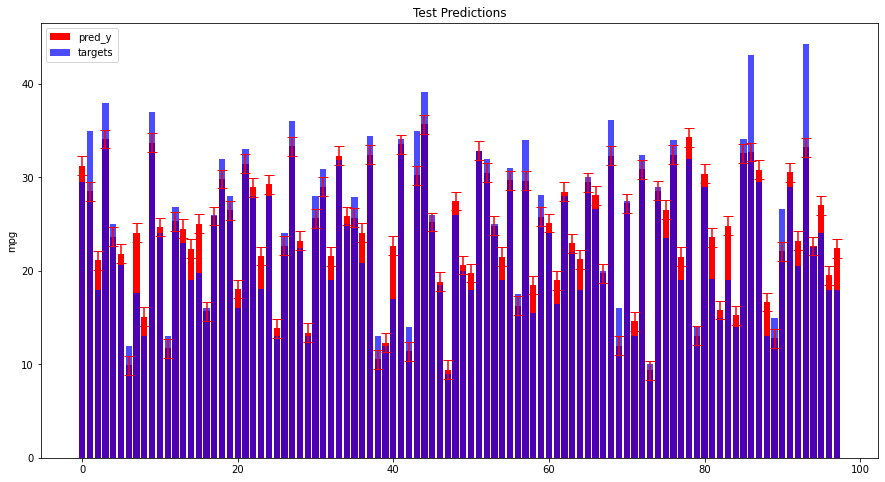

In [192]:
## Supporting Cell Do NOT change

def plot_predictions_bar(pred_y, targets, std_dev):
    upper_line = pred_y + std_dev; lower_line = pred_y - std_dev
    plt.bar(range(len(pred_y)), pred_y, label='pred_y', color='r')
    plt.bar(range(len(pred_y)), targets, label='targets', color='b', alpha=0.7)
    plt.errorbar(range(len(pred_y)), pred_y, yerr=np.stack([pred_y-lower_line, upper_line-pred_y], axis=0), capsize=5, ls = 'none', color='r')
    plt.legend()

def relative_error(targets, pred_y):
    return (np.abs(targets-pred_y)/targets).mean()*100

def plot_regression(initial_w_mean, initial_w_cov, line_x, line_y, data_x, data_y, train_features, train_targets, test_features, test_targets, beta):
    # Learn best distribution over the parameter space
    new_w_mean, new_w_cov = update_w_mean_and_cov(initial_w_mean, initial_w_cov, train_features, train_targets, beta)

    # Get the distribution over targets for the training data
    train_pred_mean, train_pred_cov = predictive_dist(train_features, new_w_mean, new_w_cov, beta)
    train_pred = train_pred_mean.reshape(-1)
    train_pred_std_dev = np.sqrt(np.diag(train_pred_cov)).reshape(-1)

    print('Train Relative Error', relative_error(train_targets.reshape(-1), train_pred))
    # Uncomment the following lines if you want to visualise the train set predictions
#     plt.figure(figsize=(15,8))
#     plt.title("Train Predictions")
#     plt.ylabel('mpg')
#     plot_predictions_bar(train_pred, train_targets.reshape(-1), train_pred_std_dev)
#     plt.show()
#     print()

    # Get the distribution over targets for the test data
    test_pred_mean, test_pred_sigma = predictive_dist(test_features, new_w_mean, new_w_cov, beta)
    test_pred = test_pred_mean.reshape(-1)
    test_pred_std_dev = np.sqrt(np.diag(test_pred_sigma)).reshape(-1)

    print('Test Relative Error', relative_error(test_targets.reshape(-1), test_pred))
    plt.figure(figsize=(15,8))
    plt.title("Test Predictions")
    plt.ylabel('mpg')
    plot_predictions_bar(test_pred, test_targets.reshape(-1), test_pred_std_dev)
    plt.show()
    print()
plot_regression(initial_w_mean, initial_w_cov, line_x, line_y, data_x, data_y, train_features, train_targets, test_features, test_targets, beta)

# Section 2: Shallow Neural Network Representation Power

In the first few weeks of SML we have extensively discussed the representative limitations of linear models, and many way to improve it. The following questions are intended to give you some familiarity with the representation power of shallow Neural Networks. In particular, we start by reason through a small neural network that aims to learn the XOR pattern.

## XOR with Logistic Regression

Consider a classifier given by
$$
\begin{align}
y([x_1,x_2]) &= \sigma\left([w_1,w_2,w_3]^T[x_1,x_2,1]\right)\\
        &= \sigma\left(w_1x_1+w_2x_2+w_3\right).
\end{align}
$$

We want to have the XOR relationship
$$
\begin{array}{ll|l|l}
 x_1 & x_2 & y(x_1,x_2) \\ \hline
 -1    & -1    & 1            \\
 -1    & 1     & 0            \\
 1     & -1    & 0           \\
 1     & 1    & 1           \\
\end{array}
$$

We will consider the weights $[w_1,w_2,w_3]$ that solve the XOR problem if threshold at 0.5 gives the results in the above table (i.e. $y(x_1,x_2)<0.5\implies y=0$ and $y(x_1,x_2)\geq 0.5\implies y=1$).


### Question 2.1 [10 Marks]
Show that there is no possible set of weights $[w_1,w_2,w_3]$ that can solve this.

From the table, we can derive the four inequalities:  

(1) $\sigma(-w_1 - w_2 + w_3) \geq 0.5$  
(2) $\sigma(-w_1 + w_2 + w_3) < 0.5 $  
(3) $\sigma(w_1 - w_2 + w_3) < 0.5 $  
(4) $\sigma(w_1 + w_2 + w_3) \geq 0.5 $  


which further gives us another four inequalities:  
$(1) \iff -w_1 - w_2 + w_3 \geq 0$  
$(2) \iff -w_1 + w_2 + w_3 < 0$  
$(3) \iff w_1 - w_2 + w_3 < 0$  
$(4) \iff w_1 + w_2 + w_3 \geq 0$  

From (2) and (4) we have $w_1 + w_2 \leq w_3 < w_1 -w_2$. This inequality holds if $w_2$ is negative.

From (1) and (3) we have $-w_1 - w_2 \leq w_3 < -w_1 + w_2$. This inequality does not hold if $w_3$ is negative. 

Since there is no set of weights that satify all 4 inequalities, we cannot find a set of weights $[w_1, w_2, w_3]$ that can solve this task. 

### Question 2.2 [10 Marks]
Now consider an extra basis functions $x_1^2, x_1x_2, x_2^2$, so that we have 
$$
\begin{align}
y([x_1,x_2]) &= \sigma\left([w_1,w_2,w_3,w_4,w_5,w_6]^T[x_1,x_2,x_1^2,x_2^2,x_1x_2,1]\right)\\
        &= \sigma\left(w_1x_1+w_2x_2+w_3x_1^2+w_4x_2^2+w_5x_1x_2+w_6\right).
\end{align}
$$

Show that there is a possible set of weights $[w_1,w_2,w_3,w_4,w_5,w_6]$ that can solve the XOR problem (i.e., give an example of weights which solves the XOR problem).

An example of weights that can solve the above problem is: $w_1 = 1, w_2 = 1, w_3 = 1, w_4 = 1, w_5 = 5, w_6 = 1$.

To demonstrate that it does solve the XOR problem, we have 

- With $x_1 = x_2 = -1$: 

$$
\begin{align}
y(x_1, x_2) &= \sigma(w_1x_1+w_2x_2+w_3x_1^2+w_4x_2^2+w_5x_1x_2+w_6) \\
    &= \sigma(-w_1 - w_2 + w_3 + w_4 + w_5 + w_6) \\
    &= \sigma(-1 - 1 + 1 + 1 + 5 + 1) \\
    &= \sigma(6) \\
    &= 0.9975 \geq 0.5.
\end{align}
$$

- With $x_1 = -1$ and $x_2 = 1$:

$$
\begin{align}
y(x_1, x_2)  &= \sigma(-w_1 + w_2 + w_3 + w_4 - w_5 + w_6) \\
    &= \sigma(-1 + 1 + 1 + 1 - 5 + 1) \\
    &= \sigma(-2) \\
    &= 0.1192 < 0.5.
\end{align}
$$

- With $x_1 = 1$ and $x_2 = -1$:

$$
\begin{align}
y(x_1, x_2)  &= \sigma(w_1 - w_2 + w_3 + w_4 - w_5 + w_6) \\
    &= \sigma(1 - 1 + 1 + 1 - 5 + 1) \\
    &= \sigma(-2) \\
    &= 0.1192 < 0.5.
\end{align}
$$

- With $x_1 = x_2 = 1$:

$$
\begin{align}
y(x_1, x_2)  &= \sigma(w_1 + w_2 + w_3 + w_4 + w_5 + w_6) \\
    &= \sigma(1 + 1 + 1 + 1 + 5 + 1) \\
    &= \sigma(10) \\
    &= 0.9999 \geq 0.5.
\end{align}
$$

### Question 2.3 [10 Marks]
Show that without using extra basis functions, we can solve using a 1 Hidden Layer MLP with 2 nodes in the hidden layer. In other words
$$
\begin{align}
        y([x_1,x_2]) &= \sigma\left([w_7,w_8,w_9]^T\left[\sigma\left([w_1,w_2,w_3]^T[x_1,x_2,1]\right),\sigma\left([w_4,w_5,w_6]^T[x_1,x_2,1]\right),1\right]\right)\\
        &= \sigma\left(w_7\sigma(w_1x_1+w_2x_2+w_3)+w_8\sigma(w_4x_1+w_5x_2+w_6)+w_9\right)
\end{align}
$$

To test your values, put them into the vector $w$ given and use run the plot.

That is **together** solve the for the weights in a Markdown block **and** then input your weights into the code block below that.

In [18]:
def set_weights():
    w = [2,2,-1,-2,-2,-1.5,1,1,5] 
    return w

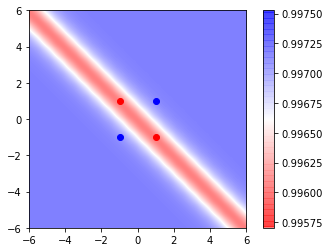

In [19]:
## Supporting Cell Do NOT change

cur_w = set_weights()

assert len(cur_w) == 9
sigmoid = lambda z : 1/(1+np.exp(-z))
model = lambda x1, x2 : sigmoid(cur_w[6]*sigmoid(cur_w[0]*x1+cur_w[1]*x2+cur_w[2]) + cur_w[7]*sigmoid(cur_w[3]*x1+cur_w[4]*x2+cur_w[5]) + cur_w[8])
y, x = np.mgrid[-6:6:200j, -6:6:200j]
im = plt.imshow(model(x, y), origin='lower', extent=[-6,6,-6,6], cmap='bwr_r', alpha=0.5)
plt.scatter(-1,1, c='r')
plt.scatter(1,-1, c='r')
plt.scatter(-1,-1, c='b')
plt.scatter(1,1, c='b')
plt.colorbar(im)
plt.show()

## Better Representations

### Question 2.4 [15 Marks]
Although the weights you get above solve th XOR problem for those 4 points (hopefully!) they don't solve the problem for the general XOR problem, which is to predict 0 for Quadrants 2 and 4 of the 2D plane, and predict 1 for Quadrants 1 and 3 of the XOR plane. 

Use [this online tool](https://playground.tensorflow.org/) to find weights for a 1 layer HLP with the least number of neurons in the hidden layer and no extra features that solves the problem (it has the general XOR problem as one of the toy problems). Make sure to change the Activation to Sigmoid and the Data to Exclusive or, and keep everything else as default.  Here we will use the term solve if it gets <=0.05 test loss.

Rather than using individual functions like the previous plotting code, when implementing Neural Networks we usually use matrix multiplication and elementwise non-linear operations. See if you can recreate the network you made on the online tool in the code below and get the same plot.

In [230]:
num_inputs = 2
num_hidden = 3 # TODO: improve on this, and then fill in the next three properly
#weights_1 = np.array([[0.9,-1.4],[-1.9,-0.72],[-0.61,-1.9],[0.43,0.85],[-1.9,0.99],[1.6,-1.4],[-0.61,-0.54],[0.97,0.77]]) # Shape is (num_hidden, num_inputs)
weights_1 = np.array([[-1.1,0.50],[-0.36, 0.91],[1.1, 1.2]]) # Shape is (num_hidden, num_inputs)

#biases_1 = np.array([2.8,3.3,2.7,-2.1,2.9,1.6,-0.3,2.8])
biases_1 = np.array([-3.0, 2.4, 4.5])

#weights_2 = np.array([4.4,-3.8,-2.8,1.7,6.0,2.2,0.86,-5.7])
weights_2 = np.array([-7.4, 8.7, -7.4])

biases_2 = -0.15 # They haven't showed the bias value, but its pretty easy to tune to make the plot look like theirs

assert weights_1.shape == (num_hidden, num_inputs), weights_1.shape
assert weights_2.shape == (num_hidden,), weights_2.shape
assert biases_1.shape == (num_hidden,), biases_1.shape

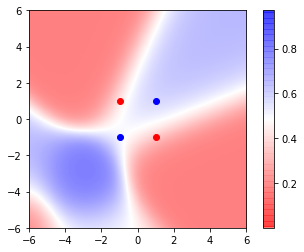

In [231]:
## Supporting Cell Do NOT change

model = lambda x: sigmoid(sigmoid(x@weights_1.T + biases_1) @ weights_2 + biases_2) # x should have shape (2,) or (n, 2)

y, x = np.mgrid[-6:6:200j, -6:6:200j]
values = model(np.stack([x, y], axis=-1).reshape(200*200,2)).reshape(200,200)
im = plt.imshow(values, origin='lower', extent=[-6,6,-6,6], cmap='bwr_r', alpha=0.5)
plt.scatter(-1,1, c='r')
plt.scatter(1,-1, c='r')
plt.scatter(-1,-1, c='b')
plt.scatter(1,1, c='b')
plt.colorbar(im)
plt.show()

### Question 2.5 [5 Marks]
Try the same with the spiral dataset in the online tool (and using the Sigmoid activation). You may use more layers and more features (basis functions) as neccessary, and put the ratio of training data up to 90%. Take a screenshot and post your result below (don't need to spend too long playing around).

In [22]:
### Solution

from IPython.display import Image

image_path = "Q2-5.png"  ### TODO

assert(image_path in SUBMISSION_LIST)

# Do not remove this exception
try:
    Image(filename=image_path)
except FileNotFoundError:
    pass    

# Code to Package Your Assignment
Run the following code block to upload to gradescope:

In [23]:
import zipfile

with zipfile.ZipFile(f'{U_ID}_assignment_1.zip', 'w') as f:
    for s in SUBMISSION_LIST:
        f.write(s)